/home/piotrek/.cache/pypoetry/virtualenvs/inxai-gu_zuGSa-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/piotrek/.cache/pypoetry/virtualenvs/inxai-gu_zuGSa-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True


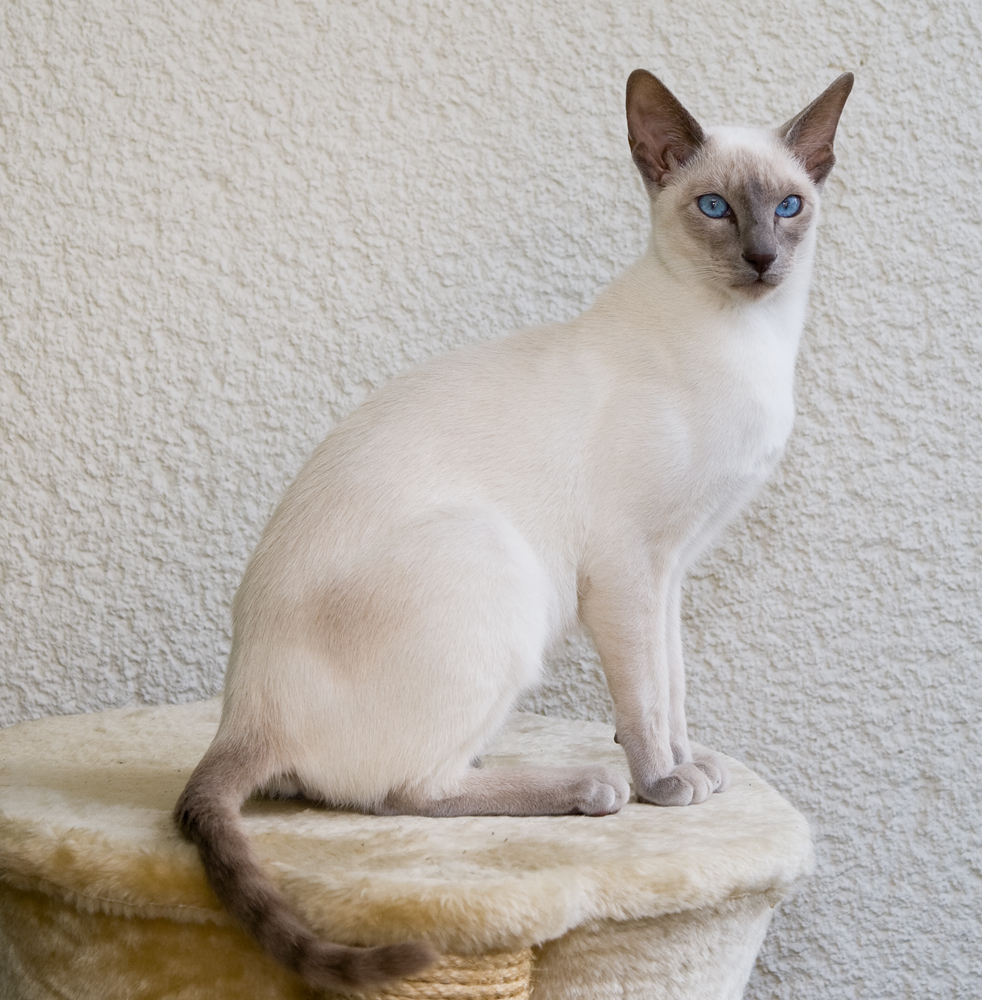

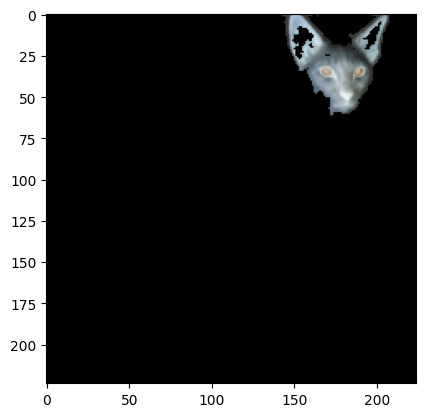

In [1]:
from crp.helper import get_layer_names
from matplotlib import pyplot as plt
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image, ImageOps
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.image import imgify, vis_opaque_img
import torchvision.transforms as transforms
import torchvision

cc = ChannelConcept()

# mask channel 0 and 2 in batch 0
mask_fn = cc.mask(0, [0, 2])

mask_fn(torch.ones((2, 4, 2, 2)))

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = vgg16_bn(True).to(device)
model.eval()

composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)



transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image = Image.open("images/Siam_lilacpoint.jpg")
image
sample = transform(image).unsqueeze(0).to(device)

# compute heatmap wrt. output 284 (green lizard class)
conditions = [{"y": 284}]

# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite, mask_map=cc.mask)

# or use a dictionary for mask_map
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

attr = attribution(sample, conditions, composite, mask_map=mask_map)
print(torch.equal(attr[0], attr.heatmap))
# print(attr.heatmap)

# x = attr.heatmap.clone() 
heatmap = imgify(attr.heatmap,symmetric=True)
future = imgify(attr.heatmap,symmetric=True)

# applying grayscale method
future = ImageOps.grayscale(future)
# q = x.copy()
# x.show()

future = ImageOps.invert(future)
future = future.point(lambda x: 255 if x>25 else 0)
future
xzxzx = future.convert('L')

qqqq = torchvision.transforms.functional.pil_to_tensor(future)
# plt.imshow(transforms.ToPILImage()(qqqq), interpolation="bicubic")

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), ])
sample2 = transform(image).to(device)

# aaaa = torchvision.transforms.functional.pil_to_tensor(image)
zzzzz = qqqq * sample2
plt.imshow(transforms.ToPILImage()(zzzzz))
image
